In [95]:
import vedo
import napari
import numpy as np
from pygeodesic import geodesic
import napari_process_points_and_surfaces as nppas

In [96]:
import os
import watershed_udder as wu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyrealsense2 as rs
from astropy.convolution import Gaussian2DKernel, convolve,interpolate_replace_nans
import open3d as o3d
from astropy.convolution import Gaussian2DKernel, convolve,interpolate_replace_nans
import open3d as o3d
from scipy.ndimage import gaussian_filter
from scipy.linalg import lstsq
from scipy.spatial import Delaunay
import math

In [97]:
def points_toworld(points):
    points2 = points.copy()
    for i in range(len(points)):
        points2[i, :] = rs.rs2_deproject_pixel_to_point(intr, [points[i, 0], points[i, 1]], points[i, 2])
    return points2

In [98]:
# list files 
dirpath = os.getcwd()
ws_dir = r"validate_watershed\watershed_segments"
corr_dir = r"validate_watershed\watershed_correspondence"
label_dir = os.path.join(dirpath, r"validate_watershed\pred_labels")
kp_dir = os.path.join(label_dir, r"keypoints")
sg_dir = os.path.join(label_dir, r"segments")
img_dir = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_video\depth_images")
results = pd.read_csv(r"validate_watershed\ws_class_predictions_I.csv")
good = results[results.thr09 == 1]
filenames = [file.replace(".npy", "") for file in os.listdir(ws_dir)]
cows = set()
filenames2 = []
for file in filenames: 
    cow = file.split("_")[0]
    if cow not in cows:
        cows.add(cow)
        filenames2.append(file)

video_path =  os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_video\video_files\example_video.bag")

results_df = pd.DataFrame(columns = ["cow", "filename", "volume", "lf_vol", "rf_vol", "lb_vol", "rb_vol"])

config = rs.config()
rs.config.enable_device_from_file(config, video_path, repeat_playback = False)
pipeline = rs.pipeline()
cfg = pipeline.start(config) # Start pipeline and get the configuration it found
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intr = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics
# depth_sensor = profile.as_video_stream_profile().get_device().first_depth_sensor()
# depth_scale = depth_sensor.get_depth_scale()

# quarter assignment - according to ws_map 
# lf - yelow (255,255,0)
# rf - cian (0, 255, 255)
# lb - magenta (255, 0, 255)
# rb - white (255,255,255)
# background - black
color_dict = {"lf":[1,1,0], "rf": [0, 1, 1], "lb":[1, 0,1], "rb":[0.5,0.5,0.5], "bg": [0, 0, 0]}

for file in good.filename[:1]:
    cow = file.split("_")[0]
    cow_line = {"cow": cow, "filename":file, "volume": np.nan, "lf_vol":np.nan, "rf_vol": np.nan, "lb_vol":np.nan, "rb_vol":np.nan}
    # udder object
    udder = wu.udder_object(file + ".tif", img_dir, label_dir, array = 0)
    # read image
    img = udder.img
    # read labels
    segment = udder.get_segment()
    points = udder.get_keypoints()
    # reas WS segmentation
    ws_label = np.load(os.path.join(ws_dir, file + ".npy"))
    kp_ws = pd.read_csv(os.path.join(corr_dir, file +".csv")).loc[0].to_dict()
    ws_map = dict((v, k) for k, v in kp_ws.items())
    ws_map[0] = "bg"
    new_kp = wu.update_kp(kp_ws, ws_label, img)
    scale = 0.001
    img = udder.img.copy().astype(float)
    img[img ==0] = np.nan
    kernel = Gaussian2DKernel(x_stddev=1)
    udder_conv = interpolate_replace_nans(img, kernel)
    udder_conv[np.isnan(udder_conv)] = 0
    
    masked_udder =  udder.get_mask() * udder_conv 
    rows, cols = np.nonzero(masked_udder)
    values = masked_udder[rows, cols]
    quarter_lbls = ws_label[rows, cols]
    quarter_colors = quarter_colors = np.array([color_dict[ws_map[point]] if point in ws_map.keys() else [0,0,0]for point in quarter_lbls ])
    udder_points = np.column_stack((np.transpose(cols), np.transpose(rows), np.transpose(values))).astype(float)
    udder_points[:, 2] = udder_points[:, 2] *scale
    pts = points_toworld(udder_points)

In [99]:
udder_points = np.column_stack((np.transpose(cols), np.transpose(rows), np.transpose(values))).astype(float)
kp_points = np.column_stack((udder_points, np.zeros((len(udder_points),1))))
kp_points[(udder_points[:, 0] == new_kp["rf"][0]) & (udder_points[:, 1] == new_kp["rf"][1]), 3] = 2
kp_points[(udder_points[:, 0] == new_kp["lf"][0]) & (udder_points[:, 1] == new_kp["lf"][1]), 3] = 3
udder_points[:, 2] = udder_points[:, 2] *scale
pts = points_toworld(udder_points)

In [100]:
segment = np.round([[coord[1] * udder.size[0]-1, coord[0]* udder.size[1]-1] for coord in udder.get_segment()]).astype(int)
cols = segment[:, 1]
rows = segment[:, 0]
values = udder_conv[rows, cols]*scale
segment_points = np.column_stack((np.transpose(cols), np.transpose(rows), np.transpose(values))).astype(float)
sgpts = points_toworld(segment_points)
# %%
filtered = sgpts.copy()
med = np.mean(sgpts[:,2])
std = np.std(sgpts[:,2])
filtered = filtered[sgpts[:,2]<=med+2*std] 
filtered[:, 2] = gaussian_filter(filtered[:,2], 1, truncate = 2)
#%%  
X = np.column_stack((np.ones((len(filtered), 1)), filtered[:, :2]))
z = np.transpose(filtered[:, 2])

b = np.matrix(z).T
A = np.matrix(X)

fit, residual, rnk, s = lstsq(A, b)

predz =  fit[1] * pts[:,0] + fit[2] * pts[:,1] + fit[0]
croped = pts.copy()
quarter_colors = quarter_colors[croped[:,2] <= predz[:]]
quarter_lbls = quarter_lbls[croped[:,2] <= predz[:]]
kp_points = kp_points[croped[:,2] <= predz[:]]
croped = croped[croped[:,2] <= predz[:]]

plane = croped.copy()
plane[:, 2] = fit[1] * croped[:,0] + fit[2] * croped[:,1] + fit[0]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(croped)
# pcd.points = o3d.utility.Vector3dVector(pts)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
plane_pcd = o3d.geometry.PointCloud()
plane_pcd.points = o3d.utility.Vector3dVector(plane)
plane_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
pcd.colors = o3d.utility.Vector3dVector(quarter_colors)
#o3d.visualization.draw_geometries([pcd, plane_pcd])
center = plane_pcd.get_center()
a = fit[1][0]
b = fit[2][0]
c = -1
d = fit[0][0]
cos_theta = c / math.sqrt(a**2 + b**2 + c**2)
sin_theta = math.sqrt((a**2+b**2)/(a**2 + b**2 + c**2))
u_1 = b / math.sqrt(a**2 + b**2 )
u_2 = -a / math.sqrt(a**2 + b**2)
rotation_matrix = np.array([[cos_theta + u_1**2 * (1-cos_theta), u_1*u_2*(1-cos_theta), u_2*sin_theta],
                            [u_1*u_2*(1-cos_theta), cos_theta + u_2**2*(1- cos_theta), -u_1*sin_theta],
                            [-u_2*sin_theta, u_1*sin_theta, cos_theta]])
pcd.rotate(rotation_matrix, center = center)
plane_pcd.rotate(rotation_matrix, center = center)
xyz = np.asarray(pcd.points)
floor = np.min(xyz[:, 2])
xyz[:, 2] = xyz[:, 2]-floor
xy_catalog = []
for point in xyz:
    xy_catalog.append([point[0], point[1]])
tri = Delaunay(np.array(xy_catalog))
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)

# volume using napari

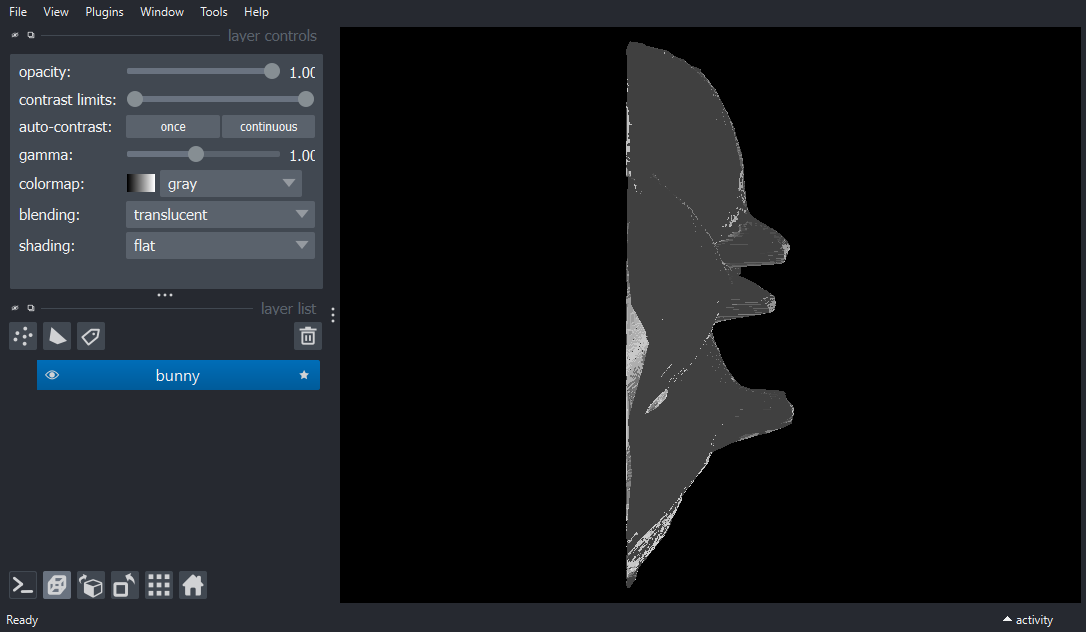

In [104]:
x = np.where(kp_points[:, 3]== 2)
y = np.where(kp_points[:, 3] == 3)
mesh = vedo.Mesh([np.array(surface.vertices), np.array(surface.triangles)])
bunny = (mesh.points(), np.asarray(mesh.faces()).astype(int))
viewer = napari.Viewer(ndisplay=3)
viewer.add_surface(bunny)
napari.utils.nbscreenshot(viewer)

In [105]:
print('Surface area:', mesh.area())
print('Volume:', mesh.volume())

Surface area: 0.20959620590725234
Volume: 0.005753359037176437


In [106]:
geoalg = geodesic.PyGeodesicAlgorithmExact(mesh.points(), mesh.faces())
distance, path = geoalg.geodesicDistance(x[0], y[0])
print('Measured distance:', distance)
vectors = []
for i in range(len(path)-1):
    vectors.append(path[i+1] - path[i])

vectors = np.asarray(vectors)
napari_vectors_geodesics = np.stack([path[:-1], vectors]).transpose((1,0,2))
viewer.add_vectors(napari_vectors_geodesics, edge_width=0.01, edge_color='blue')

Measured distance: 0.25063179684591996


C:\Users\marie\AppData\Local\Temp\ipykernel_3732\52693735.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance, path = geoalg.geodesicDistance(x[0], y[0])


<Vectors layer 'napari_vectors_geodesics' at 0x1c01df60160>

## volume using the pile method

In [107]:
import functools 

def points_toworld(points):
    points2 = points.copy()
    for i in range(len(points)):
        points2[i, :] = rs.rs2_deproject_pixel_to_point(intr, [points[i, 0], points[i, 1]], points[i, 2])
    return points2

def get_triangles_vertices(triangles, vertices):
    triangles_vertices = []
    for triangle in triangles:
        new_triangles_vertices = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        triangles_vertices.append(new_triangles_vertices)
    return np.array(triangles_vertices)

def volume_under_triangle(triangle):
    p1, p2, p3 = triangle
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    return abs((z1+z2+z3)*(x1*y2-x2*y1+x2*y3-x3*y2+x3*y1-x1*y3)/6)

In [108]:
volume = functools.reduce(lambda a, b:  a + volume_under_triangle(b), get_triangles_vertices(surface.triangles, surface.vertices), 0)*1000
volume

5.852801315260146

## geodesic distance by hand

In [109]:
teat_line = wu.udder_line(udder, udder.get_shape(), new_kp["rf"], new_kp["lf"])
teat_line = teat_line[~np.isnan(teat_line[:, 2])]
teat_line[:, 2] = teat_line[:, 2]*scale
teat_line= points_toworld(teat_line)
n = len(teat_line)

In [110]:
geo_dist = 0
for i in range(n-1):
    A = teat_line[i]
    B = teat_line[i+1]
    dist = np.sqrt((B[0]-A[0])**2+(B[1]-A[1])**2+(B[2]-A[2])**2)
    geo_dist  = geo_dist + dist

In [111]:
geo_dist

0.9780076277701412